In [1]:
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
import math
import itertools
import sys
import os
import seaborn as sns
import pandas as pd

sys.path.insert(0, 'C:/Users/Stephanie/Documents/GitHub/mwc_induction/code/analysis')
import mwc_induction_utils as mwc
mwc.set_plotting_style()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

 ## How can we determine the allosteric parameter?

The allosteric parameter $\Delta \varepsilon_{AI}$ has proven elusive. This is partially because it is essentially impossible to fit from the simple repression IPTG titration curves; a wide range of allosteric parameter values give equally good fits. Additionally, for simple repression titration curves in which we vary R by changing the LacI RBS, the allosteric parameter can be absorbed into the energy term, rendering it invisible. The LacI-operator binding energies from Garcia 2011 are effective energies that include both $\Delta \varepsilon_{AI}$ and the actual LacI-operator binding energy. This is the one parameter in the MWC framework for LacI simple repression for which our models have been almost entirely unhelpful. However, titration experiments in which the number of operators is greater than 1 may enable us to determine the value of $\Delta \varepsilon_{AI}$.

In their Brewster 2014, fold-change was measured for systems with various operator copy numbers using the equation 

\begin{equation}
\mathrm{fold-change} = \frac{\sum_{m=0}^{\mathrm{min}(N,R)} \frac{R!}{(N_{NS})^m(R-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}} (N-m)}{N \sum_{m=0}^{\mathrm{min}(N,R)} \frac{R!}{(N_{NS})^m(R-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}}},
\end{equation}

where $R$ is the number of repressors, $N$ is the number of operators, and $e^{-\beta \Delta \epsilon_\mathrm{DNA}}$ is the binding energy between LacI and the operator. This model assumes that all of the repressors are active and available for binding to operators. However, this may not be true; if the number of inactive repressors in the system is signficant, this model will not correctly describe the titration curve. In this notebook, we explore a model for including the probability that a repressor is active, $p_A$, in the expression for fold-change, which allows us to fit for $\Delta \varepsilon_{AI}$. 

## The fraction of active repressors is dependent only on $\Delta \varepsilon_{AI}$

Our simplest model for LacI allostery says that the probability that a repressor is active, $p_A$, is determined by $e^{-\beta\epsilon}$ using the equation $p_A = \frac{1}{1 + e^{-\beta\epsilon}}$. This can be incorporated into the model for fold change by simply substituting $R_A = p_A R_\mathrm{tot}$ for $R$, giving us the equation 

\begin{equation}
\mathrm{fold-change} = \frac{\sum_{m=0}^{\mathrm{min}(N,R_A)} \frac{R_A!}{(N_{NS})^m(R_A-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}} (N-m)}{N \sum_{m=0}^{\mathrm{min}(N,R_A)} \frac{R_A!}{(N_{NS})^m(R_A-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}}}.
\end{equation}

We write a function for this model:

In [2]:
def fold_change_var_N(Reff, e_AI, N, Op):
    '''
    Computes the fold-change for N >= 1
    Parameters
    ----------
    Reff : array-like
        Array with the values of all repressor copy numbers
    e_AI : float
        Energetic difference between the active and inactive state
    N : float
        Number of operators available for repressor binding
    Op : float
        Binding energy between operator and repressor as inferred in Garcia 2011
    Returns
    -------
    fold-change
    '''

    pA = 1/(1 + np.exp(-e_AI))     #probability that a given repressor is active
    Rtot = Reff/pA
    Op = Op + np.log(pA)    #Convert Hernan energy values to actual energy values
    NNS = 4.6E6    #Number of nonspecific sites
    fc = []      #This will be my fold-change array
    
    if type(Reff)==np.ndarray:
        for R in Reff: #Here I use a loop to perform the summation and calculate fold-change
            t = 0
            b = 0
            for m in range(0, min(int(mp.floor(R)), int(mp.floor(N)))+1):
                t += mp.fprod([mp.fdiv(mp.factorial(mp.floor(R)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(R - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op), mp.floor(N)-mp.mpf(m)])
                b += mp.fprod([mp.fdiv(mp.factorial(mp.floor(R)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(R - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op)])
            fc.append(float(t/(mp.floor(N)*b)))
    else:
        t = 0
        b = 0
        for m in range(0, min(int(mp.floor(Reff)), int(mp.floor(N)))+1):
            t += mp.fprod([mp.fdiv(mp.factorial(mp.floor(Reff)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(Reff - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op), mp.floor(N)-mp.mpf(m)])
            b += mp.fprod([mp.fdiv(mp.factorial(mp.floor(Reff)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(Reff - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op)])
        fc.append(float(t/(mp.floor(N)*b)))
    return (Rtot, fc)

Elsewhere we have fit for $\Delta \varepsilon_{AI}$ using data from Brewster 2014. Below, we import these data and show how a) plots of fold-change vary with $\Delta \varepsilon_{AI}$ and b) the Brewster data are described by the fitted curves. 

In [4]:
# Load data from Brewster 2014

data_file = '/Users/sbarnes/Dropbox/mwc_induction_team/tidy_lacI_multiple_operator_data.csv'
df= pd.read_csv(data_file)

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


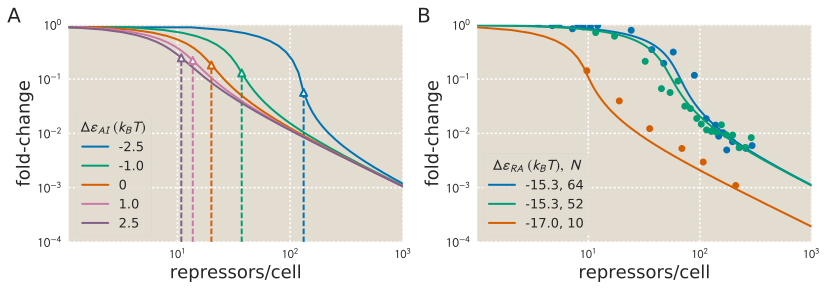

In [5]:
# Establish parameters

Reff = np.arange(0., 1000., 1)
N = 10
N_vals = np.array(df.N.unique(), dtype=float)
e_AI = 4.5
e_AI_array = [-2.5, -1.0, 0, 1.0, 2.5]
O1 = -15.3

# Set color palette
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]


#Plot a) curves showing how e_AI affects curve and b) plots showing fits to Brewster 2014 data

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 4))

for i in range(0,len(e_AI_array)):
    fold_change = fold_change_var_N(Reff, e_AI_array[i], N, O1)
    x_coord = N * (1 + np.exp(-e_AI_array[i]))
    x_coord_Reff = x_coord/(1 + np.exp(-e_AI_array[i]))
    point = fold_change_var_N(x_coord_Reff, e_AI_array[i], N, O1)
    ax1.plot(x_coord, point[1], marker='^', fillstyle='full',\
             markerfacecolor='white', markeredgecolor=colors[i], markeredgewidth=2.0, zorder=(i + 5))
    ax1.plot([x_coord, x_coord], [0, point[1][0]], '--', color=colors[i])
    ax1.plot(fold_change[0], fold_change[1], color = colors[i], label = e_AI_array[i])

for j in range(len(N_vals)):
    val = N_vals[j]
    energy = df.energy[df.N==val].unique()[0]
    reps = np.array(df.repressor[df.N==val])
    fc = np.array(df.fold_change[df.N==val])
    ax2.plot(reps, fc, 'o', color=colors[j], label=None)
    ax2.plot(fold_change_var_N(Reff, e_AI, val, energy)[0],\
             fold_change_var_N(Reff, e_AI, val, energy)[1], color=colors[j], label=('%.1f, %.0f' % (energy, val)))

# Make labels

title_dict = {ax1:r'$\Delta \varepsilon_{AI}\ (k_BT)$', ax2:r'$\Delta \varepsilon_{RA}\ (k_BT),\ N$'}     
for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('repressors/cell')
    ax.set_ylabel('fold-change')
    ax.set_xlim(0, 1000)
    ax.set_ylim(1E-4, 1)
    leg = ax.legend(loc='lower left', title=title_dict[ax])
    leg.get_title().set_fontsize(15)

plt.figtext(0.005, 0.95, 'A', fontsize=20)
plt.figtext(0.5, 0.95, 'B', fontsize=20)
plt.tight_layout()
#plt.savefig('titeffect_a.pdf', bbox_inches='tight')